In [1]:
import numpy as np
import os

import copy

Set up variables for constants such as absolute datapaths and the desired valdiation fraction split.

In [9]:
#gnps
datapath = "G:\\Dev\\Data\\For Family\\GNPS Python Master\\Final Data.txt"
fingerprints_path = "G:\\Dev\\Data\\For Family\\GNPS Python Master\\Final Fingerprints.txt"
fingerprints_names_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Fingerprint Legend.txt"

#gnps for family
gnps_for_family_datapath = "G:\\Dev\\Data\\For Family Q3\\GNPS Python Master\\Final Data.txt"
fingerprints_for_family_gnps_path = "G:\\Dev\\Data\\For Family Q3\\GNPS Python Master\\Final Fingerprints.txt"

#mibig
mibig_fingerprints_path = "G:\\Dev\\Data\\Fingerprint Bitmaps 2\\mibig_unique_smiles.txt"
mibig_families_path = "G:\\Dev\\Data\\Final Smiles Families.txt"
mibig_filtered_fingerprints_path = "G:\\Dev\\Data\\Filtered Mibig GNPS Links\\Filtered Mibig Fingerprints.tsv"
mibig_filtered_families_path = "G:\\Dev\\Data\\mibig_family.txt"

#npatlas
npatlas_smiles_fingerprints_path = "G:\\Dev\\Data\\Fingerprint Bitmaps 2\\NPAtlas_DB_last_version_filtered.txt"
npatlas_final_families_path = "G:\\Dev\\Data\\NPAtlas_Final_Families.txt"

#test
test_datapath = "G:\\Dev\\Data\\For Family Test Q3\\GNPS Python Master\\Final Data.txt"
test_fingerprint_path = "G:\\Dev\\Data\\For Family Test Q3\\GNPS Python Master\\Final Fingerprints.txt"

linked_fingerprints_path = "G:\\Dev\\Data\\Linked GNPS Fingerprints.tsv"
families_names_path = "G:\\Dev\\Data\\Family Legend.txt"

num_samples = 5770
num_smiles_families_samples = 1368
val_fraction = 0.1

Import methods from ultilities

In [10]:
from nn_evaluation_interface import plot_loss, compute_auc, evaluate
from nn_files_load_interface import *
from nn_interface import simplified_fingerprint_model, simplified_family_model
from nn_training_splits_interface import train_diff_splits

Load the data to variables

In [11]:
spectra = load_master_file(path=datapath)
fingerprints = load_fingerprints_master(path=fingerprints_path)

gnps_spectra = load_master_file(path=gnps_for_family_datapath)
gnps_fingerprints = load_fingerprints_master(path=fingerprints_for_family_gnps_path, number_of_rows=1)

mibig_fingerprints = load_fingerprints_master(path=mibig_fingerprints_path)
mibig_families = load_families_master(path=mibig_families_path)
mibig_filtered_fingerprints = load_fingerprints_master(path=mibig_filtered_fingerprints_path, number_of_rows=1)
mibig_filtered_families = load_families_master(path=mibig_filtered_families_path)

fingerprint_names = load_fingerprint_legend(path=fingerprints_names_path)
family_names = load_family_legend(path=families_names_path)

test_spectra = load_master_file(path=test_datapath)
test_fingerprint = load_fingerprints_master(path=test_fingerprint_path)

print("Done")

Done


The training/evaluation process

C:\Dev\nnpredict\Code\Python\nn_interface.py:117: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  auto_model = Model(input=input_layer, output=out_layer)


Train on 5702 samples, validate on 634 samples
Epoch 1/100
5702/5702 [==============================] - 8s 1ms/step - loss: 0.5402 - val_loss: 0.3387
Epoch 2/100
5702/5702 [==============================] - 4s 668us/step - loss: 0.1931 - val_loss: 0.1636
Epoch 3/100
5702/5702 [==============================] - 4s 784us/step - loss: 0.1241 - val_loss: 0.1336
Epoch 4/100
5702/5702 [==============================] - 4s 702us/step - loss: 0.1122 - val_loss: 0.1227
Epoch 5/100
5702/5702 [==============================] - 4s 781us/step - loss: 0.1076 - val_loss: 0.1170
Epoch 6/100
5702/5702 [==============================] - 4s 757us/step - loss: 0.1051 - val_loss: 0.1135
Epoch 7/100
5702/5702 [==============================] - 6s 1ms/step - loss: 0.1035 - val_loss: 0.1110
Epoch 8/100
5702/5702 [==============================] - 5s 913us/step - loss: 0.1022 - val_loss: 0.1092
Epoch 9/100
5702/5702 [==============================] - 5s 890us/step - loss: 0.1012 - val_loss: 0.1077
Epoch 10/100

5702/5702 [==============================] - 4s 637us/step - loss: 0.0816 - val_loss: 0.0865
Epoch 78/100
5702/5702 [==============================] - 4s 638us/step - loss: 0.0815 - val_loss: 0.0864
Epoch 79/100
5702/5702 [==============================] - 4s 641us/step - loss: 0.0813 - val_loss: 0.0862
Epoch 80/100
5702/5702 [==============================] - 5s 961us/step - loss: 0.0812 - val_loss: 0.0861
Epoch 81/100
5702/5702 [==============================] - 4s 659us/step - loss: 0.0810 - val_loss: 0.0860
Epoch 82/100
5702/5702 [==============================] - 4s 675us/step - loss: 0.0809 - val_loss: 0.0859
Epoch 83/100
5702/5702 [==============================] - 5s 814us/step - loss: 0.0807 - val_loss: 0.0858: 0s - loss:
Epoch 84/100
5702/5702 [==============================] - 4s 711us/step - loss: 0.0806 - val_loss: 0.0857
Epoch 85/100
5702/5702 [==============================] - 5s 868us/step - loss: 0.0804 - val_loss: 0.0856
Epoch 86/100
5702/5702 [=======================

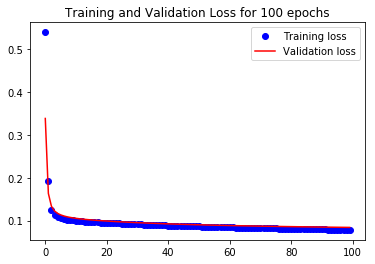

Done
(array([(  0, 182, 0.73049451,   0. ), (  1, 177, 0.68768362,   0.2),
       (  2, 156, 0.65551839,   0. ), (  3,  18, 0.36141304,  96.8),
       (  4,  90, 0.57589286,   2. ), (  5,   2, 0.59      ,  32.6),
       (  6,   0, 0.        , 100. ), (  7,  12, 0.61315789,   8.8),
       (  8,   0, 0.        , 100. ), (  9,   0, 0.        , 100. ),
       ( 10,   0, 0.        , 100. ), ( 11, 117, 0.64635495,   0. ),
       ( 12,  40, 0.58179012,   5.8), ( 13, 104, 0.63628336,   0. ),
       ( 14,  19, 0.62007478,   4.6), ( 15,  54, 0.5518018 ,  14.6),
       ( 16,  12, 0.57324561,  18.6), ( 17,  17, 0.3990461 ,  92.6),
       ( 18,   2, 0.3925    ,  70.2), ( 19,   0, 0.        , 100. ),
       ( 20,   0, 0.        , 100. ), ( 21,   0, 0.        , 100. ),
       ( 22,  57, 0.523049  ,  29.6), ( 23,  43, 0.43644873,  90.4),
       ( 24,   8, 0.47551546,  61. ), ( 25,  10, 0.634375  ,   7. ),
       ( 26,   0, 0.        , 100. ), ( 27,   4, 0.30555556,  90.2),
       ( 28,   0, 0.        

In [5]:
# Training network 1 (exclude links)
epochs = 100
x_train_spectra = np.log(gnps_spectra+1)
x_train_fingerprints = gnps_fingerprints.values
x_test_spectra = np.log(test_spectra+1)

enc1 = simplified_fingerprint_model(x_train_spectra, x_train_fingerprints, epochs=epochs)

actual = test_fingerprint.values
predicted = enc1.predict(x_test_spectra)

print(compute_auc(320, actual, predicted))

In [ ]:
# Training network 1 (include links)
epochs = 100
x_train_spectra = np.log(spectra+1)
x_train_fingerprints = fingerprints.values

enc1 = simplified_fingerprint_model(x_train_spectra, x_train_fingerprints, epochs=epochs)

In [ ]:
# Training network 2 (exclude links)
epochs = 100
x_train_fingerprints = mibig_filtered_fingerprints
x_train_families = mibig_filtered_families

enc2 = simplified_family_model(x_train_fingerprints.values, x_train_families.values, epochs=epochs)

C:\Dev\nnpredict\Code\Python\nn_interface.py:157: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  auto_model = Model(input=input_layer, output=out_layer)


Train on 1231 samples, validate on 137 samples
Epoch 1/100
1231/1231 [==============================] - 1s 902us/step - loss: 0.5226 - val_loss: 0.3818
Epoch 2/100
1231/1231 [==============================] - 1s 451us/step - loss: 0.3585 - val_loss: 0.3259
Epoch 3/100
1231/1231 [==============================] - 1s 635us/step - loss: 0.3297 - val_loss: 0.3123
Epoch 4/100
1231/1231 [==============================] - 1s 692us/step - loss: 0.3170 - val_loss: 0.3045
Epoch 5/100
1231/1231 [==============================] - 1s 563us/step - loss: 0.3073 - val_loss: 0.2983
Epoch 6/100
1231/1231 [==============================] - 1s 634us/step - loss: 0.2990 - val_loss: 0.2928
Epoch 7/100
1231/1231 [==============================] - 1s 553us/step - loss: 0.2917 - val_loss: 0.2878
Epoch 8/100
1231/1231 [==============================] - 1s 469us/step - loss: 0.2852 - val_loss: 0.2833
Epoch 9/100
1231/1231 [==============================] - 0s 395us/step - loss: 0.2793 - val_loss: 0.2792
Epoch 10

Epoch 78/100
1231/1231 [==============================] - 1s 555us/step - loss: 0.1653 - val_loss: 0.2089
Epoch 79/100
1231/1231 [==============================] - 1s 531us/step - loss: 0.1646 - val_loss: 0.2086
Epoch 80/100
1231/1231 [==============================] - 1s 563us/step - loss: 0.1639 - val_loss: 0.2084
Epoch 81/100
1231/1231 [==============================] - 1s 528us/step - loss: 0.1631 - val_loss: 0.2082
Epoch 82/100
1231/1231 [==============================] - 1s 504us/step - loss: 0.1624 - val_loss: 0.2080
Epoch 83/100
1231/1231 [==============================] - 1s 524us/step - loss: 0.1617 - val_loss: 0.2078
Epoch 84/100
1231/1231 [==============================] - 1s 501us/step - loss: 0.1610 - val_loss: 0.2076
Epoch 85/100
1231/1231 [==============================] - 1s 563us/step - loss: 0.1603 - val_loss: 0.2074
Epoch 86/100
1231/1231 [==============================] - 1s 531us/step - loss: 0.1596 - val_loss: 0.2072
Epoch 87/100
1231/1231 [======================

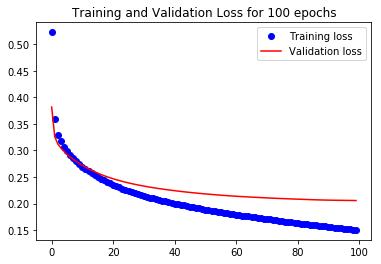

In [12]:
# Training network 2 (include links)
epochs = 100
x_train_fingerprints = mibig_fingerprints
x_train_families = mibig_families

enc2 = simplified_family_model(x_train_fingerprints.values, x_train_families.values, epochs=epochs)

In [ ]:
filepath = "G:\\Dev\\Data\\saved_spectrum_fingerprint_non_binary_model.h5"
enc1.save(filepath)

filepath = "G:\\Dev\\Data\\saved_fingerprint_families_non_binary_model.h5"
enc2.save(filepath)

In [13]:
# using linked mibig-gnps as test set
x_train_spectra = load_master_file(path=test_datapath)
predicted = enc1.predict(x_train_spectra)

gnps_families_path = "G:\\Dev\\Data\\gnps_family.txt"
x_train_families = load_families_master(gnps_families_path)
x_train_fingerprints = load_fingerprints_master(test_fingerprint_path, number_of_rows=1)

actual = x_train_families.values
predicted = enc2.predict(x_train_fingerprints.values) # using true fingerprints
#predicted = enc2.predict(predicted) # using predicted fingerprints
exp_stats, exp_perm_scores = compute_auc(8, actual, predicted)

print(exp_stats)
print()
print(exp_perm_scores)
print()

Done
[(0, 14, 0.94908815,   0. ) (1, 63, 0.72022382,   0. )
 (2,  7, 0.78388278,   1. ) (3, 12, 0.92982456,   0. )
 (4,  0, 0.        , 100. ) (5, 10, 0.9453125 ,   0. )
 (6, 91, 0.96663697,   0. ) (7, 23, 0.66553316,   0.2)]

[[0.47112462 0.48575228 0.29141337 ... 0.54844225 0.54863222 0.46181611]
 [0.40459061 0.52095466 0.45512162 ... 0.47093754 0.45432226 0.43074112]
 [0.53333333 0.82234432 0.503663   ... 0.56446886 0.42161172 0.45164835]
 ...
 [0.503125   0.54661458 0.52239583 ... 0.45208333 0.44244792 0.54921875]
 [0.45990496 0.46930997 0.53895654 ... 0.46841897 0.45995446 0.4984655 ]
 [0.49392762 0.51165897 0.38559631 ... 0.59533641 0.49514209 0.44389118]]



In [14]:
# using mibig all as test dataset
x_train_fingerprints = mibig_fingerprints
x_train_families = mibig_families

actual = x_train_families.values
predicted = enc2.predict(x_train_fingerprints.values) # using true fingerprints
exp_stats, exp_perm_scores = compute_auc(8, actual, predicted)

print(exp_stats)
print()
print(exp_perm_scores)
print()

Done
[(0,  79, 0.97442822,  0.) (1, 482, 0.92773362,  0.)
 (2, 123, 0.97289973,  0.) (3,  68, 0.99029977,  0.)
 (4,   1, 0.12874909, 89.) (5,  98, 0.97739033,  0.)
 (6, 680, 0.94360251,  0.) (7, 176, 0.89642122,  0.)]

[[0.45103161 0.47491923 0.50625055 ... 0.43845685 0.45707103 0.51158783]
 [0.49298446 0.48221528 0.50517501 ... 0.50236037 0.5334526  0.51648394]
 [0.47195938 0.51093153 0.4969602  ... 0.50802886 0.50460378 0.51072257]
 ...
 [0.49936928 0.50367186 0.48497509 ... 0.52834244 0.49127832 0.48041941]
 [0.48573337 0.48406186 0.51647786 ... 0.52916061 0.47950368 0.48519793]
 [0.51710742 0.51565837 0.50249056 ... 0.49715909 0.51307724 0.53203173]]



In [ ]:
families = ["Alkaloid", "NRP", "Terpene", "RiPP", "Nucleoside", "Saccharide", "Polyketide", "Other"]
family_dict = {}
family_counter_dict = {}
family_missed_highest = {}
mol_family_dict = {}

for family in families:
    family_dict[family] = 0
    family_counter_dict[family] = 0
    family_missed_highest[family] = 0
    
# with open(gnps_families_path, 'r') as f:
with open(families_path, 'r') as f:
    for line in f:
        mol_id, family_index, value = line.split("  ")
        family_dict[families[int(family_index)]] += 1
        
        if mol_id not in mol_family_dict:
            mol_family_dict[mol_id] = {}
            mol_family_dict[mol_id]["families"] = []
            mol_family_dict[mol_id]["probabilities"] = []
            
        mol_family_dict[mol_id]["families"].append(families[int(family_index)])
        
print(family_dict)

for index, probabilities in enumerate(predicted):
    probabilities = list(probabilities)
    mol_family_dict[x_train_families.index[index]]["probabilities"] = probabilities 
    true_labels = mol_family_dict[x_train_families.index[index]]["families"]
    index_of_maximum = probabilities.index(max(probabilities))
    if families[index_of_maximum] in true_labels:
        family_counter_dict[families[index_of_maximum]] += 1

for family in families:
    for id, details in mol_family_dict.items():
        index_of_maximum = details["probabilities"].index(max(details["probabilities"]))
        if family not in details["families"] and index_of_maximum == families.index(family):
            family_missed_highest[family] += 1
            
print(family_counter_dict)
print(family_dict)
print(family_missed_highest)

print("Family, proportion guessed correctly, proportion missed")
for family in family_dict:
    if family_dict[family] == 0:
        print(family, "no sample")
    else:
        print(family + ", " + str(family_counter_dict[family]/family_dict[family] * 100) +
             ", " + str(family_missed_highest[family]/(1813-family_dict[family]) * 100))

In [ ]:
mibig_links_path = "G:\\Dev\\Data\\mibig_gnps_links_q3_loose.csv"
mibig_family_path = "G:\\Dev\\Data\\mibig_family\\gene_family.txt"
mibig_gnps_df = pd.read_csv(mibig_links_path, sep=",")

mibig_gnps_dict = {}
mibig_families = {}
mibig_families_count = {}

for index, row in mibig_gnps_df.iterrows():
    if row["gnps_id"] not in mibig_gnps_dict:
        mibig_gnps_dict[row["gnps_id"]] = set()
    mibig_gnps_dict[row["gnps_id"]].add(row["#mibig_id"])

with open(mibig_family_path, 'r') as f:
    for line in f:
        mibig_id, family = line.split("  ")
        if mibig_id not in mibig_families:
            mibig_families[mibig_id] = []
        mibig_families[mibig_id].append(family[:-1])
        
probability_report_path = "G:\\Dev\\Data\\gnps_prediction_report.csv"
families = ["Alkaloid", "NRP", "Terpene", "RiPP", "Nucleoside", "Saccharide", "Polyketide", "Other"]
true_family_counter = {}
family_correct_counter = {}

for family in families:
    true_family_counter[family] = 0
    family_correct_counter[family] = 0

with open(probability_report_path, 'w') as f:
    f.write("#mibig_id,gnps_id,Alkaloid,NRP,Terpene,RiPP,Nucleoside,Saccharide,Polyketide,Other,True Label\n")

with open(probability_report_path, 'a') as f:    
    for index, probabilities in enumerate(predicted):
        temp = copy.deepcopy(probabilities).tolist()
        gnps_id = x_train_fingerprints.index[index]
        prob_string = ",".join(map(str, probabilities))
        for mibig_id in mibig_gnps_dict[gnps_id]:
            true_labels = []
            max_indexes = []
            for true_family in mibig_families[mibig_id]:
                true_labels.append(true_family)
                max_index = temp.index(max(temp))
                max_indexes.append(max_index)
                temp.remove(temp[max_index])
                true_family_counter[true_family] += 1
                f.write(mibig_id + "," + gnps_id + "," + prob_string + "," + true_family + "\n")
            for index in max_indexes:
                if families[index] in true_labels:
                    family_correct_counter[families[index]] += 1
    
prediction_comparison_report_path = "G:\\Dev\\Data\\prediction_comparison_report.txt"
with open(prediction_comparison_report_path, 'w') as f:
    f.write("family,matched,actual,proportion\n")

with open(prediction_comparison_report_path, 'a') as f:
    for family in family_correct_counter:
        matched = family_correct_counter[family]
        actual = true_family_counter[family]
        proportion = 0
        if actual != 0:
            proportion = matched / actual
        f.write(family + "," + str(matched) + "," + str(actual) + "," + str(proportion*100) + "\n")
    
print("Done")